# Fig S7 plotting

### Standard imports

In [15]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import matplotlib as mpl
from cycler import cycler
import pylab

# Plotting parameters
sns.set_context("talk", font_scale=1, rc={"lines.linewidth": 2.0, 'lines.markersize': 5})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
mpl.rc('axes', prop_cycle=(cycler('color', ['r', 'k', 'b','g','y','m','c']) ))
mpl.rc('text', usetex=False)
tw = 1.5
sns.set_style({"xtick.major.size": 12, "ytick.major.size": 12,
               "xtick.minor.size": 8, "ytick.minor.size": 8,
               'axes.labelsize': 48,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})
mpl.rc('xtick', labelsize=24) 
mpl.rc('ytick', labelsize=24)
mpl.rc('axes', linewidth=1.75)
plt.gcf().subplots_adjust(bottom=0.15)
sns.set_style({'axes.labelsize': 48, 'axes.titlesize': 48})
cm = 1/2.54


# Color variables
cb_green = (102/255, 194/255, 165/255, 0.5)
cb_orange = (252/255, 141/255, 98/255, 0.5)
cb_blue = (141/255, 160/255, 203/255, 0.5)
cb_darkblue = (141/255, 160/255, 203/255, 0.25)
alpha_grey = (215/255, 215/255, 215/255, 1.0)
very_alpha_blue = (.75, .75, 1)
cb_yellow = (255/255, 217/255, 47/255)
cb_pink = (231/255, 138/255, 195/255)
alpha_val = 0.5
alpha_red = (alpha_val + 1/2, alpha_val, alpha_val)
alpha_black = (alpha_val, alpha_val, alpha_val)
alpha_blue = (alpha_val, alpha_val, alpha_val + 1/2)

%matplotlib inline

### Import data

In [2]:
df = pd.read_excel('./data/CFU_counts.xlsx', sheet_name='Fig S7')

### Calculate transfer rates

In [4]:
df.head()

,Replicate,Message Cargo,Receiver gRNA,Strain Type,Dilution,Colonies,CFUs/mL
0,1,YFP,A,Sender,20000000,9,180000000
1,1,YFP,A,Receiver,2000000,37,74000000
2,1,YFP,A,Transconjugant,2000,6,12000
3,1,Weak BxbI,A,Sender,20000000,24,480000000
4,1,Weak BxbI,A,Receiver,2000000,24,48000000


In [5]:
# Get transfer rates
rate_df = pd.DataFrame(columns=[
                                'Message Cargo',
                                'Receiver gRNA',
                                'Transfer Rate',
                                'Geomean Transfer Rate',
                                ])

reps = [1,2]
cargos = ['YFP', 'Weak BxbI', 'Strong BxbI']
gRNAs = ['A','B']

for c in range(len(cargos)):
    for g in range(len(gRNAs)):
        rates = np.empty(len(reps))
        for r in range(len(reps)):
            rep = reps[r]
            cargo = cargos[c]
            gRNA = gRNAs[g]

            S = df[(df['Replicate'] == rep) &
                   (df['Message Cargo'] == cargo) &
                   (df['Receiver gRNA'] == gRNA) &
                   (df['Strain Type'] == 'Sender')]['CFUs/mL'].values
            R = df[(df['Replicate'] == rep) &
                   (df['Message Cargo'] == cargo) &
                   (df['Receiver gRNA'] == gRNA) &
                   (df['Strain Type'] == 'Receiver')]['CFUs/mL'].values
            T = df[(df['Replicate'] == rep) &
                   (df['Message Cargo'] == cargo) &
                   (df['Receiver gRNA'] == gRNA) &
                   (df['Strain Type'] == 'Transconjugant')]['CFUs/mL'].values

            assert len(S) == 1
            assert len(R) == 1
            assert len(T) == 1

            S = S[0]
            R = R[0]
            T = T[0]

            rate = T/(S*R)

            rates[r] = rate

            if r != len(reps)-1:
                tempdict = pd.DataFrame({'Replicate': rep,
                            'Message Cargo': cargo,
                            'Receiver gRNA': gRNA,
                            'Transfer Rate': rate},
                                        index=[0])
                
                rate_df = pd.concat([rate_df, tempdict],
                                    ignore_index=True)
            else:
                tempdict = pd.DataFrame({'Replicate': rep,
                            'Message Cargo': cargo,
                            'Receiver gRNA': gRNA,
                            'Transfer Rate': rate,
                            'Geomean Transfer Rate': stats.mstats.gmean(rates)
                           }, index=[0])
                
                rate_df = pd.concat([rate_df, tempdict],
                                    ignore_index=True)




In [9]:
# calculate block fidelity
# Pass transfer rate / Block transfer rate
# Higher value of Block Fidelity means more blocking

for c in range(len(cargos)):
    block_fids = np.empty(len(reps))
    for r in range(len(reps)):
        cargo = cargos[c]
        rep = reps[r]
        rate_u = rate_df[(rate_df['Message Cargo'] == cargo) &
                         (rate_df['Replicate'] == rep) &
                         (rate_df['Receiver gRNA'] == 'A')]['Transfer Rate'].values
        rate_s = rate_df[(rate_df['Message Cargo'] == cargo) &
                         (rate_df['Replicate'] == rep) &
                         (rate_df['Receiver gRNA'] == 'B')]['Transfer Rate'].values
        
        assert len(rate_u) == 1
        assert len(rate_s) == 1
        
        rate_u = rate_u[0]
        rate_s = rate_s[0]
        
        block_fid = rate_s / rate_u

        rowslice = rate_df.loc[lambda df: (df['Message Cargo'] == cargo) & (df['Replicate'] == rep) & (df['Receiver gRNA'] == 'A'), :]
        rowind = rowslice.index[0]
        
        rate_df.loc[rowind, 'Block Fidelity'] = block_fid
        
        block_fids[r] = block_fid
        
        if r == len(reps) - 1:
            rate_df.loc[rowind, 'Geomean Block Fidelity'] = stats.mstats.gmean(block_fids)
        

In [11]:
# calculate transient expression index
# YCC Block Fidelity / Integrase Block Fidelity
# Higher (>1) value of relative block fidelity means transient expression matters

teis_32 = np.empty(len(reps))
teis_34 = np.empty(len(reps))

for r in range(len(reps)):
    rep = reps[r]
    
    bf_ycc = rate_df[(rate_df['Message Cargo'] == 'YFP') &
                     (rate_df['Replicate'] == rep) & 
                     (rate_df['Receiver gRNA'] == 'A')]['Block Fidelity'].values
    bf_32 = rate_df[(rate_df['Message Cargo'] == 'Weak BxbI') &
                     (rate_df['Replicate'] == rep) & 
                     (rate_df['Receiver gRNA'] == 'A')]['Block Fidelity'].values
    bf_34 = rate_df[(rate_df['Message Cargo'] == 'Strong BxbI') &
                     (rate_df['Replicate'] == rep) & 
                     (rate_df['Receiver gRNA'] == 'A')]['Block Fidelity'].values
    
    assert len(bf_ycc) == 1
    assert len(bf_32) == 1
    assert len(bf_34) == 1
    
    bf_ycc = bf_ycc[0]
    bf_32 = bf_32[0]
    bf_34 = bf_34[0]
    
    tei_32 = bf_ycc / bf_32
    tei_34 = bf_ycc / bf_34
    
    rowslice32 = rate_df.loc[lambda df: (df['Message Cargo'] == 'Weak BxbI') & (df['Replicate'] == rep) & (df['Receiver gRNA'] == 'A'), :]
    rowind32 = rowslice32.index[0]
    rowslice34 = rate_df.loc[lambda df: (df['Message Cargo'] == 'Strong BxbI') & (df['Replicate'] == rep) & (df['Receiver gRNA'] == 'A'), :]
    rowind34 = rowslice34.index[0]
    
    rate_df.loc[rowind32, 'Transient Expression Index'] = tei_32
    rate_df.loc[rowind34, 'Transient Expression Index'] = tei_34
    
    teis_32[r] = tei_32
    teis_34[r] = tei_34

    if r == len(reps) - 1:
        rate_df.loc[rowind32, 'Geomean Transient Expression Index'] = stats.mstats.gmean(teis_32)
        rate_df.loc[rowind34, 'Geomean Transient Expression Index'] = stats.mstats.gmean(teis_34)
    

In [12]:
rate_df

,Message Cargo,Receiver gRNA,Transfer Rate,Geomean Transfer Rate,Replicate,Block Fidelity,Geomean Block Fidelity,Transient Expression Index,Geomean Transient Expression Index
0,YFP,A,0.0,NaN,1.0,182.196970,NaN,NaN,NaN
1,YFP,A,0.0,0.0,2.0,147.768879,164.082424,NaN,NaN
2,YFP,B,0.0,NaN,1.0,NaN,NaN,NaN,NaN
3,YFP,B,0.0,0.0,2.0,NaN,NaN,NaN,NaN
4,Weak BxbI,A,0.0,NaN,1.0,180.392157,NaN,1.010005,NaN
5,Weak BxbI,A,0.0,0.0,2.0,205.278592,192.433490,0.719846,0.852671
6,Weak BxbI,B,0.0,NaN,1.0,NaN,NaN,NaN,NaN
7,Weak BxbI,B,0.0,0.0,2.0,NaN,NaN,NaN,NaN
8,Strong BxbI,A,0.0,NaN,1.0,17.809725,NaN,10.230195,NaN
9,Strong BxbI,A,0.0,0.0,2.0,10.572082,13.721730,13.977273,11.957852


### Plot everything

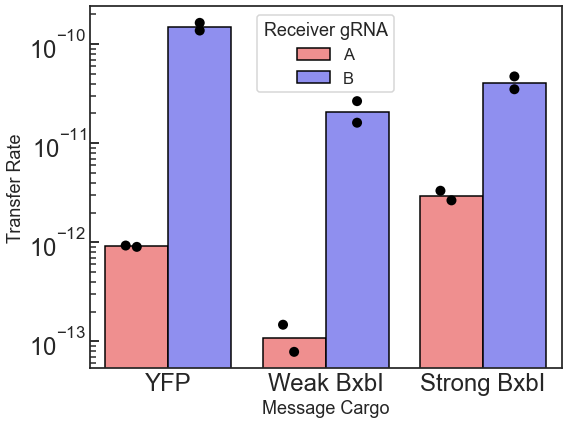

In [21]:
# Plot Transfer Rates

plt.figure(figsize=(8,6))
sns.barplot(data=rate_df, x='Message Cargo', y='Geomean Transfer Rate', hue='Receiver gRNA',
            palette=[alpha_red, alpha_blue], edgecolor='k')
sns.swarmplot(data=rate_df, x='Message Cargo', y='Transfer Rate', hue='Receiver gRNA',
              dodge=True, palette=['k'], s=10,
             )
plt.gca().set_yscale('log')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles[2:], labels=labels[2:],
          title='Receiver gRNA')
           
plt.tight_layout()
plt.savefig('./figs/Fig_S7D.pdf')
    
plt.show()


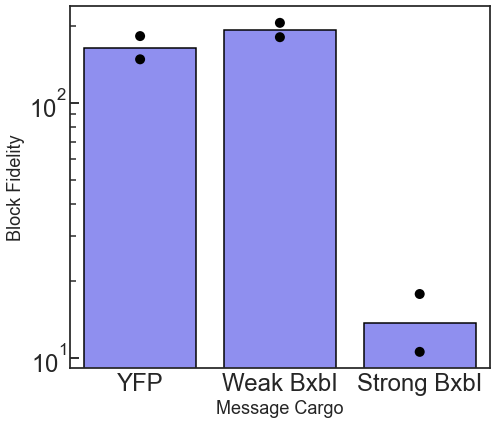

In [22]:


# Plot Block Fidelities

plt.figure(figsize=(7,6))
sns.barplot(data=rate_df, x='Message Cargo', y='Geomean Block Fidelity',
           palette=[alpha_blue], edgecolor='k')
sns.swarmplot(data=rate_df, x='Message Cargo', y='Block Fidelity',
             palette=['k'], s=10)
plt.gca().set_yscale('log')
plt.tight_layout()
plt.savefig('./figs/Fig_S7E.pdf')
plt.show()

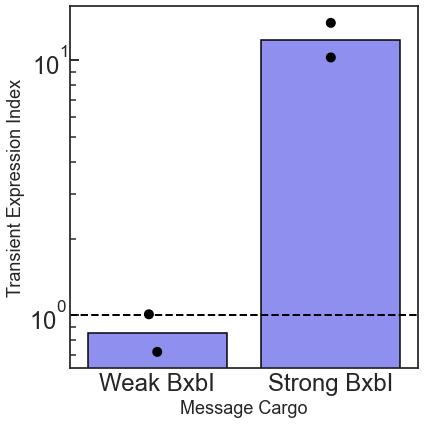

In [23]:


# Plot Transient Expression Indices

plt.figure(figsize=(6,6))
sns.barplot(data=rate_df[rate_df['Message Cargo'] != 'YFP'],
            x='Message Cargo', y='Geomean Transient Expression Index',
           palette=[alpha_blue], edgecolor='k',)
sns.swarmplot(data=rate_df[rate_df['Message Cargo'] != 'YFP'],
              x='Message Cargo', y='Transient Expression Index',
             palette=['k'], s=10)
xmin, xmax = plt.gca().get_xlim()
plt.plot([xmin, xmax], [1, 1], 'k--')
plt.gca().set_xlim((xmin, xmax))
plt.gca().set_yscale('log')
plt.tight_layout()
plt.savefig('./figs/Fig_S7F.pdf')
plt.show()